In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
__author__ = "Sreejith Sreekumar"
__email__ = "sreekumar.s@husky.neu.edu"
__version__ = "0.0.1"

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.metrics import make_scorer
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

## cross validation
from  sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from xgboost import XGBClassifier
from sklearn.svm import SVR

import pickle
import math

from scipy import sparse as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='srjit', api_key='lpKtXjzR7LBaqHwlxFQp')

In [5]:
data_path = "../data/winemag-data_first150k.csv"
data = pd.read_csv(data_path)

In [6]:
data.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


## Visualization1: EDA

What is the average wine price per country?

In [8]:
grouped_avg_price = data.groupby("country")["price"].mean().reset_index(name="average_price")
grouped_avg_price = grouped_avg_price.sort_values(by="average_price", ascending=False)
grouped_avg_price = grouped_avg_price.dropna()


_data = [go.Line(
            x=grouped_avg_price["country"],
            y=grouped_avg_price["average_price"]
    )]



layout = go.Layout(
    title='Average price of wine country-wise',
    
    xaxis=dict(
        title='Country',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Price of wine (USD)',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=_data, layout=layout)
py.iplot(fig, filename='price')

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




The plot shows the average price of wine in every country in dataset. As seen average price of wines are more in  rich countries. The increase in price could also indicate its demand in these countries - however, more information is required to confirm the answer to this.

A simple line plot helps to convey this infomation. Sorting the data by price helps the visualization more easy to interpret.

    Number of Attributes: 2
    Marks: Lines 
    Channel:
        - Position: Vertical
        - Size: Height
        
        
Ref: Lecture3 - Marks and Channels: slides 27, 28, 40, 44        

## Visualization 2: EDA

__Which country produces the most number of `unique` wines__

(What % of the unique wines are made by a country)

In [9]:
unique_wines = data.groupby(["variety","country"]).size().reset_index(name="count")
unique_wines = unique_wines[["variety","country"]]

In [10]:
wines_count = unique_wines.groupby("country").size().reset_index(name="count")
total_number_of_wines = sum(wines_count["count"])

In [11]:
# Number of unique wines in the dataset
len(data["variety"].unique())

632

__There are 632 unique wines in the dataset__

What % of all the unique wines are made by a country?

In [12]:
wines_count = wines_count.sort_values(by="count",ascending=False)

_data = [go.Bar(
            x=wines_count["country"],
            y=wines_count["count"]
    )]


layout = go.Layout(
    title='Number of unique wines available country-wise',
    
    xaxis=dict(
        title='Country',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Unique Wines Made',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=_data, layout=layout)
py.iplot(fig, filename='Number of unique wines')

The plot suggests that the most variety of wines are made from the United States. Close by are european countries known for their wines. There is a noticable correlation between the variety of wines and the average price of wines per country.

A simple line plot helps to convey this infomation. Sorting the data by price helps the visualization more easy to interpret.

Number of Attributes: 2
Marks: Bars 
Channel:

    - Position: Vertical
    - Size: Length

## Correlation Plot

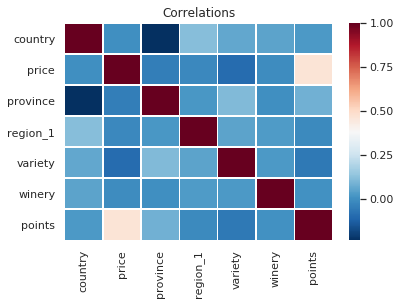

In [11]:
def encode_objects(df_):
    # we dont want the original data to be modified - using shallow copy
    df = df_.copy()
    for column in df.columns:
        if df.dtypes[column] == np.object:
            enc = LabelEncoder()
            df[column] = enc.fit_transform(df[column])
    return df

data_update = data[["country","description","designation","price","province","region_1","region_2","variety","winery","points"]]

correlation_inp = data_update[["country","price","province","region_1","variety","winery","points"]]
correlation_inp = correlation_inp.dropna()
data_ = encode_objects(correlation_inp)
correlations = data_.corr()

g1 = sns.heatmap(correlations, linewidths=.5, cmap = "RdBu_r")
plt.title("Correlations")

plt.show()

Looks are price and points have decent correlation. Higher the price, higher the correlation - However, from EDA plots (Not included in the assignment), we could see exceptions (outliers) to this - one of the wines with very good points had comparitvely low price


__region 2 has a lot of NaNs which are `not okay` for our  correlation calculations. So they've been taken out.__

In [13]:
features = ["country","description","price","province","region_1","variety","winery"]
target= 'points'

cols = ["country","description","price","province","region_1","variety","winery", "points"]

data_ = data[cols]
data_ = data_.dropna()

X = data_[features]
y = data_[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

## Vectorizing text data

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

description_train = vectorizer.fit_transform(X_train["description"])
description_test = vectorizer.transform(X_test["description"]) 

In [16]:
column_names_from_text_features = vectorizer.vocabulary_

rev_dictionary = {v:k for k,v in vectorizer.vocabulary_.items()}
column_names_from_text_features = [v for k,v in rev_dictionary.items()]

## One hot encoding to categorical attributes

In [17]:
countrycols = pd.get_dummies(X_train['country'])
provincecols = pd.get_dummies(X_train['province'])
regioncols = pd.get_dummies(X_train['region_1'])
varietycols =  pd.get_dummies(X_train['variety'])
winerycols = pd.get_dummies(X_train['winery'])



countrycols_test = pd.get_dummies(X_test['country'])
provincecols_test = pd.get_dummies(X_test['province'])
regioncols_test = pd.get_dummies(X_test['region_1'])
varietycols_test =  pd.get_dummies(X_test['variety'])
winerycols_test = pd.get_dummies(X_test['winery'])


## Scaling numeric attributes

In [19]:
scaler = StandardScaler(copy=False)
price = pd.DataFrame(scaler.fit_transform(X_train[["price"]]), columns=["price"])
price_test = pd.DataFrame(scaler.transform(X_test[["price"]]), columns=["price"])

In [20]:
# joining categorical and numeric features
X_train = pd.concat([price, countrycols, provincecols, regioncols, varietycols, winerycols], axis=1)
X_test = pd.concat([price_test, countrycols_test, provincecols_test, regioncols_test, varietycols_test, winerycols_test], axis=1)

In [21]:
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [22]:
features_to_train = list(set(X_train.columns))
features_not_in_test = list(set(features_to_train) - set(X_test.columns))
for feature in features_not_in_test:
    X_test[feature] = 0

__Keeping column names, we might need this later__

In [23]:
column_names_from_other_features = features_to_train

In [24]:
all_features = column_names_from_other_features + column_names_from_text_features

In [25]:
X_test = X_test[features_to_train]

__Constructing sparse matrices - because we have a lot of one hot encodings - this could help speed up computation.__

In [26]:
X_train = sp.csr_matrix(X_train.values)
X_test = sp.csr_matrix(X_test.values)

In [27]:
print(X_train.shape)
print(X_test.shape)

(91514, 12835)
(22879, 12835)


__Stacking the text features with the one hot encoded categorical features and scaled numeric features__

In [29]:
X_train = sp.hstack([X_train, description_train])
X_test = sp.hstack([X_test, description_test])

In [30]:
X_train.shape

(91514, 38284)

In [26]:
# save all the data as pql

# import pickle

# pickle1 = open("X_train.pickle","wb")
# pickle.dump(X_train, pickle1)
# pickle1.close()

# pickle2 = open("X_test.pickle","wb")
# pickle.dump(X_test, pickle2)
# pickle2.close()

__Let us perform a simple linear regression as our baseline model__

In [26]:
lr_clf = LinearRegression().fit(X_train, y_train)

In [27]:
# Train accuracy and Test accuracy
lr_train_score = lr_clf.score(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
#lr_varience = explained_variance_score(y_test, lr_pred)

print("MSE: ", lr_mse)
#print("Explained Varience Score: ", lr_r2)

MSE:  97.29835753175725


In [31]:
# save the model

pickle1 = open("lr_clf.pickle","wb")
pickle.dump(lr_clf, pickle1)
pickle1.close()

__Now let's try XGBoost__

In [29]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
xgb_pred = xgb_clf.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mse

15.001966869181345

In [31]:
# save the model

pickle1 = open("xgb_clf.pickle","wb")
pickle.dump(xgb_clf, pickle1)
pickle1.close()

__Let's try SVR model for the regression__

In [32]:
svr_clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr_clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [33]:
svr_pred = svr_clf.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mse

9.20836144678753

In [34]:
# save the model

pickle1 = open("svr_clf.pickle","wb")
pickle.dump(svr_clf, pickle1)
pickle1.close()

__Algorithm choices__

Logistic regression serves as our baseline model for this regression problem. For comparison models that work from two different perspectives are used.

1. XGBoost - Ensemble algorithm, well known for its success in competitions
2. SVR - Extension of the SVM classification model which tries to switch to a higher dimension and trying to find a decision boundary. 

__Cross Validation for parameter selection__

The following parameters are to be tuned for the three classifiers used:

- Linear regression with L1 (Lasso) regularization (Ref:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)   
    * Parameter(s): 
                    alpha – co-efficient of regularization term  
- XGBoost  (Ref: xgboost.cv - https://xgboost.readthedocs.io/en/latest/python/python_api.html)
    * Parameter(s): 
                    max_depth – Maximum tree depth for base learners.
                    learning_rate – Boosting learning rate (xgb’s “eta”)
                    n_estimators – Number of boosted trees to fit.
- Kernel type and 'c' value for the SVR model  (Ref. https://scikit-learn.org/stable/modules/grid_search.html)
    * Parameter(s): 
                    c – width of the decision boundary 
                    kernel – rbf, poly etc.
                    

__Evaluation Metric__: __Mean Squared Error__

           Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
           
           neg_mean_squared_error

__Lasso Regression__

In [29]:
alphas = [0.005, 0.05, 0.5, 1.0, 5]

Save the lasso grid model
lr_cv_clf = LassoCV(alphas=alphas, cv=10, n_jobs=-1).fit(X_train, y_train)
lr_clf_pred = lr_cv_clf.predict(X_train)


# write the model to a pickle file
pickle1 = open("lr_cv_clf.pickle","wb")
pickle.dump(lr_cv_clf, pickle1)
pickle1.close()

__XGBoost__

Grid search cross validation for optimal hyperparameters of the XGBoost Model and save the model.

In [33]:
param_dist = {
                'n_estimators': [5, 10, 20, 30],
                'learning_rate': [0.01, 0.01, 0.1],
                'max_depth': [3, 4, 5, 6]
             }
                                  
xgb_cv_clf = GridSearchCV(XGBClassifier(), 
                         param_grid = param_dist, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10,
                         n_jobs = -1)

xgb_cv_clf.fit(X_train, y_train)

# write the model to a pickle file
pickle1 = open("xgb_cv_clf.pickle","wb")
pickle.dump(xgb_cv_clf, pickle1)
pickle1.close()

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 30], 'learning_rate': [0.01, 0.01, 0.1], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

__SVR Model__


Grid search cross validation for searching optimal hyperparameters and save the model

In [ ]:
param_dist = {
                'C': [0.1, 1, 10],
                'kernel': ['rbf','poly']
             }
                                  
svr_cv_clf = GridSearchCV(SVR(), 
                         param_grid = param_dist, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10,
                         n_jobs = -1)

svr_cv_clf.fit(X_train, y_train)


# write the model to a pickle file
pickle1 = open("svr_cv_clf.pickle","wb")
pickle.dump(svr_cv_clf, pickle1)
pickle1.close()

__Load the three saved classifiers__

In [33]:
lr_cv_clf_serialized = open("lr_cv_clf.pickle",'rb')
lr_cv_clf_ = pickle.load(lr_cv_clf_serialized)

#Mean Squared Error for each CV iteration
print(lr_cv_clf_.mse_path_)

[[10.73992333 10.9621676  10.73034955 10.56735145 10.92926707 10.97853574
  10.75894734 10.79112262 10.53711029 10.90260388]
 [ 9.44808498  9.51743258  9.37817915  9.2419539   9.51536233  9.57135688
   9.42060504  9.42624894  9.22121609  9.50954322]
 [ 8.86243776  8.76364143  8.55933215  8.47065644  8.69973076  8.78357182
   8.5629874   8.61422283  8.49501892  8.97517112]
 [ 8.62961513  8.40783133  7.98463842  7.94260075  8.18640597  8.29009489
   7.9059341   8.05103065  8.03726805  8.94392639]
 [ 6.05099954  5.86467675  5.56108954  5.50195769  5.72186975  5.75710158
   5.60735264  5.62552793  5.70134137  6.23481536]]


__Since the minimal value of mse, the better the classifier is, the best performing _lasso_ model has a cv score
of 5.5__

In [34]:
xgb_cv_clf_serialized = open("xgb_cv_clf.pickle",'rb')
xgb_cv_clf_ = pickle.load(xgb_cv_clf_serialized)
print(xgb_cv_clf_.best_params_)
print(xgb_cv_clf_.best_score_)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30}
-4.801855453810346


__Best performing XGBoost model has a CV score of 4.8__

The positive of the \_best_score_ is the actual MSE (Ref: https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error ) 

In [35]:
svr_cv_clf_serialized = open("svr_cv_clf.pickle",'rb')
svr_cv_clf_ = pickle.load(svr_cv_clf_serialized)
print(svr_cv_clf_.best_params_)
print(svr_cv_clf_.best_score_)

{'C': 10, 'kernel': 'rbf'}
-7.8389406231122605


__Best performing SVR model has a CV score of 7.83__

There is only one tunable parameter for Lasso LR (lambda). So only simplecross validation is required here.

However, in the case of XGBoost and SVR models, we have multiple tunable parameters - A grid search or a random search would be appropriate in this case. Since random search is taking more time than anticipated, grid search was used.

## Visualization 3: Comparison of Classifiers

In [36]:
# Distributions of MSE in various cross validations of LR

number_of_hyperparameters = len(lr_cv_clf_.mse_path_)
mse_values_lr_unflattened = []

for i in range(10):
    tmp = []
    for j in range(number_of_hyperparameters):
        tmp.append(lr_cv_clf_.mse_path_[j][i])
    mse_values_lr_unflattened.append(tmp)

distribution_id_lr = [[i] * number_of_hyperparameters for i in range(10)]
iteration_id_lr = [item for sublist in distribution_id_lr for item in sublist]
mse_values_lr = [item for sublist in mse_values_lr_unflattened for item in sublist]


###########   For SVR and XGBOOST   ###########   


key_names = ['split' + str(i) + '_test_score' for i in range(10)]




# Distributions of MSE in various cross validations of XGBoost
xgb_variations = [xgb_cv_clf_.cv_results_[key_name] for key_name in key_names]

number_of_combinations_in_each_iteration = len(xgb_variations[0])
distribution_id_xgboost = [[i] * number_of_combinations_in_each_iteration for i in range(10)]

## now flatten out both
mse_values_xgboost = [item for sublist in xgb_variations for item in sublist]
iteration_id_xgboost = [item for sublist in distribution_id_xgboost for item in sublist]
mse_values_xgboost = [abs(item) for item in mse_values_xgboost]




# Distributions of MSE in various cross validations of SVR
svr_variations = [svr_cv_clf_.cv_results_[key_name] for key_name in key_names]
number_of_combinations_in_each_iteration = len(svr_variations[0])
distribution_id_svr = [[i] * number_of_combinations_in_each_iteration for i in range(10)]

## now flatten out both
mse_values_svr = [item for sublist in svr_variations for item in sublist]
mse_values_svr = [abs(item) for item in mse_values_svr]
iteration_id_svr = [item for sublist in distribution_id_svr for item in sublist]

In [37]:
# box plot of the distributions 



traces = [go.Box(y=xgb_variations[i]) for i in range(10)]

layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False},
          'yaxis': {'zeroline':False,'gridcolor':'white'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }


y_names = [i for i in range(10)]


import plotly.plotly as py
import plotly.graph_objs as go

data = [
    {
        'y': mse_values_xgboost,
        'x': iteration_id_xgboost,
        'name':'XGBoost',
        'marker': {
            'color': '#3D9970'
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    },
    {
        'y': mse_values_svr,
        'x': iteration_id_svr,
        'name': 'SVR',
        'marker':{
            'color': '#FF4136',
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    },
    {
        'y': mse_values_lr,
        'x': iteration_id_lr,
        'name':'Lasso Regression',
        'marker': {
            'color': '#FF851B',
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    }
]
layout = {
    'xaxis': {
        'title': 'Cross Validation Iteration ID',
        'zeroline': False,
        'tickvals':list(range(1,11))
    },
    'yaxis' : {
        'title': 'Mean Squared Error',
        'zeroline': False,
        'tickvals':list(range(0,13))
    },
    'boxmode': 'group',
    'title' : 'Distribution of MSE values for the classifiers for different hyperparameter combinations'
    
}
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

The box plot visualization shows the distribution of values of the evaluzation metric during the 10 cross validations. 

During every cross validation step, models are built for every combination of hyperparameter choices. It can be seen clearly that XGBoost is consistantly performing better than the other model types. The performance of the algorithms follow the order:

__XGBoost > Lasso Regression > SVR__


The plot is also interactive, showing the mean, median and quartile values of the distribution


 Number of Attributes: 5
 
    Marks: Boxes showing the distribution of MSE
    Channel:
    
        - Position: Both (Horizontal and Vertical) 
        - Color: Green (XGBoost), Red (SVR) and Orange (Lasso)     
        - Size: Length
        
Ref: Lecture3 - Marks and Channels: slides 27, 28, 40, 44        

## Visualization 4: Top Features Learned

Top features learned by the best performing model - __XGBoost__

In [38]:
xgb_best = xgb_cv_clf_.best_estimator_

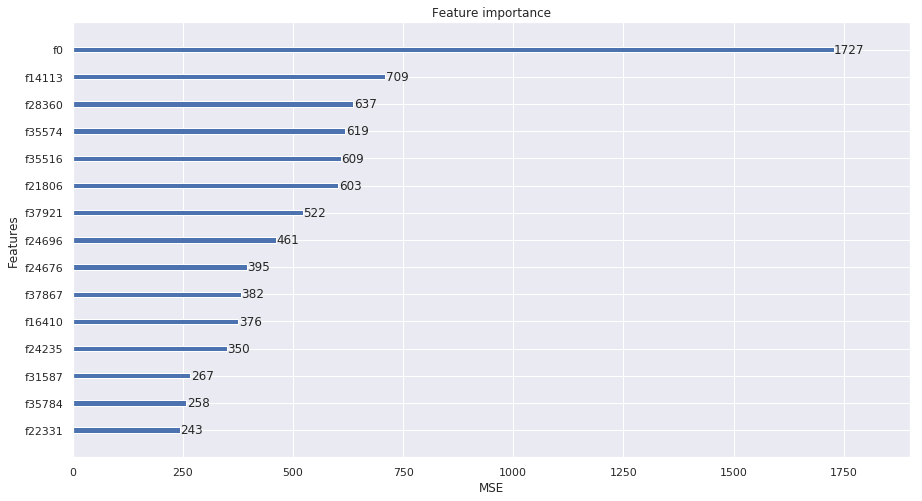

In [39]:
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

from xgboost import XGBClassifier, plot_importance

fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(xgb_best, max_num_features = 15, xlabel='MSE', ylabel='Features', ax=ax)
plt.show()

__The top features can be identified from the Y axis indices__

In [40]:
#Top Feature indices:
indices = [0, 14113, 28360, 35574, 35516, 21806, 37921, 24696, 24676, 37867, 16410, 24235, 31587, 35784, 22331]
top_features = [all_features[index] for index in indices]
top_features

['Allimant-Laugner',
 'exotic',
 'orvieto',
 'incisa',
 'attempting',
 'confines',
 'olegario',
 'jim',
 'giglio',
 'exaggerrate',
 '11',
 'invisible',
 'glceriney',
 'jewels',
 'closing']